In [4]:
# IMPORTING THE LIBRARIES 
import os
# linear algebra
import numpy as np
# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
# matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

from mpl_toolkits.mplot3d import Axes3D 
import seaborn as sns

from bokeh.palettes import Magma, Inferno, Plasma, Viridis, Cividis
# IMPORTING DATASETS
from IPython.display import clear_output
from zipfile import ZipFile
import trackml


import ipyvolume as ipv
import ipywidgets as widgets

%matplotlib inline

In [5]:
from trackml.dataset import load_event, load_dataset
from trackml.randomize import shuffle_hits
from trackml.score import score_event
from os import listdir
from os.path import isfile, join
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important;}</style>"))

event = ['event000001000', 'event000001004', 'event000001087' ]
eventFilePath = 'train_sample/train_100_events'

# Ekstract all filenames in train_100_events document
#event = [f.split('-')[0] for f in listdir(eventFilePath) if isfile(join(eventFilePath, f))]

# Load_event function from trackml library to load hits, cells, particles, truth  
for idx, e in enumerate(event):
    hits, cells, particles, truth = load_event(os.path.join('train_sample/train_100_events', e))
    
#for idx, event in enumerate(event_prefix):
#    hits, cells, particles, truth = load_event(os.path.join('train_sample/train_100_events', event))

mem_bytes = (hits.memory_usage(index=True).sum() 
             + cells.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())
print('Memory usage {:.2f} MB'.format(mem_bytes / 2**20))

Memory usage 20.82 MB


In [6]:
# Let's see the detector in more details (physical form)
df = pd.read_csv('detectors.csv')

# The detector is built from silicon slabs in cylinders and disks, which detect and measure the position/hits of the particles. 
# volume_id: numerical identifier of the detector group.
# layer_id: numerical identifier of the detector layer inside the group.
# module_id: numerical identifier of the detector module inside the layer.
# ycx, cy, cz: position of the local origin in the described in the global coordinate system (in millimeter).
# The columns needed
df[['volume_id', 'layer_id', 'module_id','module_t', 'cx', 'cy', 'cz']].head()

volume_id  layer_id  module_id  module_t        cx        cy      cz
0          7         2          1      0.15  -65.7965  -5.17830 -1502.5
1          7         2          2      0.15 -139.8510  -6.46568 -1502.0
2          7         2          3      0.15 -138.6570 -19.34190 -1498.0
3          7         2          4      0.15  -64.1764 -15.40740 -1498.0
4          7         2          5      0.15 -136.2810 -32.05310 -1502.0

In [7]:

print('Finding out the max and min of xyz so we can decide the limit in the graph')
xmin, xmax = df['cx'].min(), df['cx'].max()
ymin, ymax = df['cy'].min(), df['cy'].max()
zmin, zmax = df['cz'].min(), df['cz'].max()

print('x: %.1f  %.1f' % (xmin, xmax))
print('y: %.1f  %.1f' % (ymin, ymax))
print('z: %.1f  %.1f' % (zmin, zmax))

Finding out the max and min of xyz so we can decide the limit in the graph
x: -1021.3  1021.3
y: -1021.3  1021.3
z: -2955.5  2955.5


In [8]:
 # So we can have the 3 coordinates together

groupby = df.groupby(['volume_id', 'layer_id','module_t']).apply(lambda x: x[['cx', 'cy', 'cz']].values.tolist()).reset_index(name='xyz')

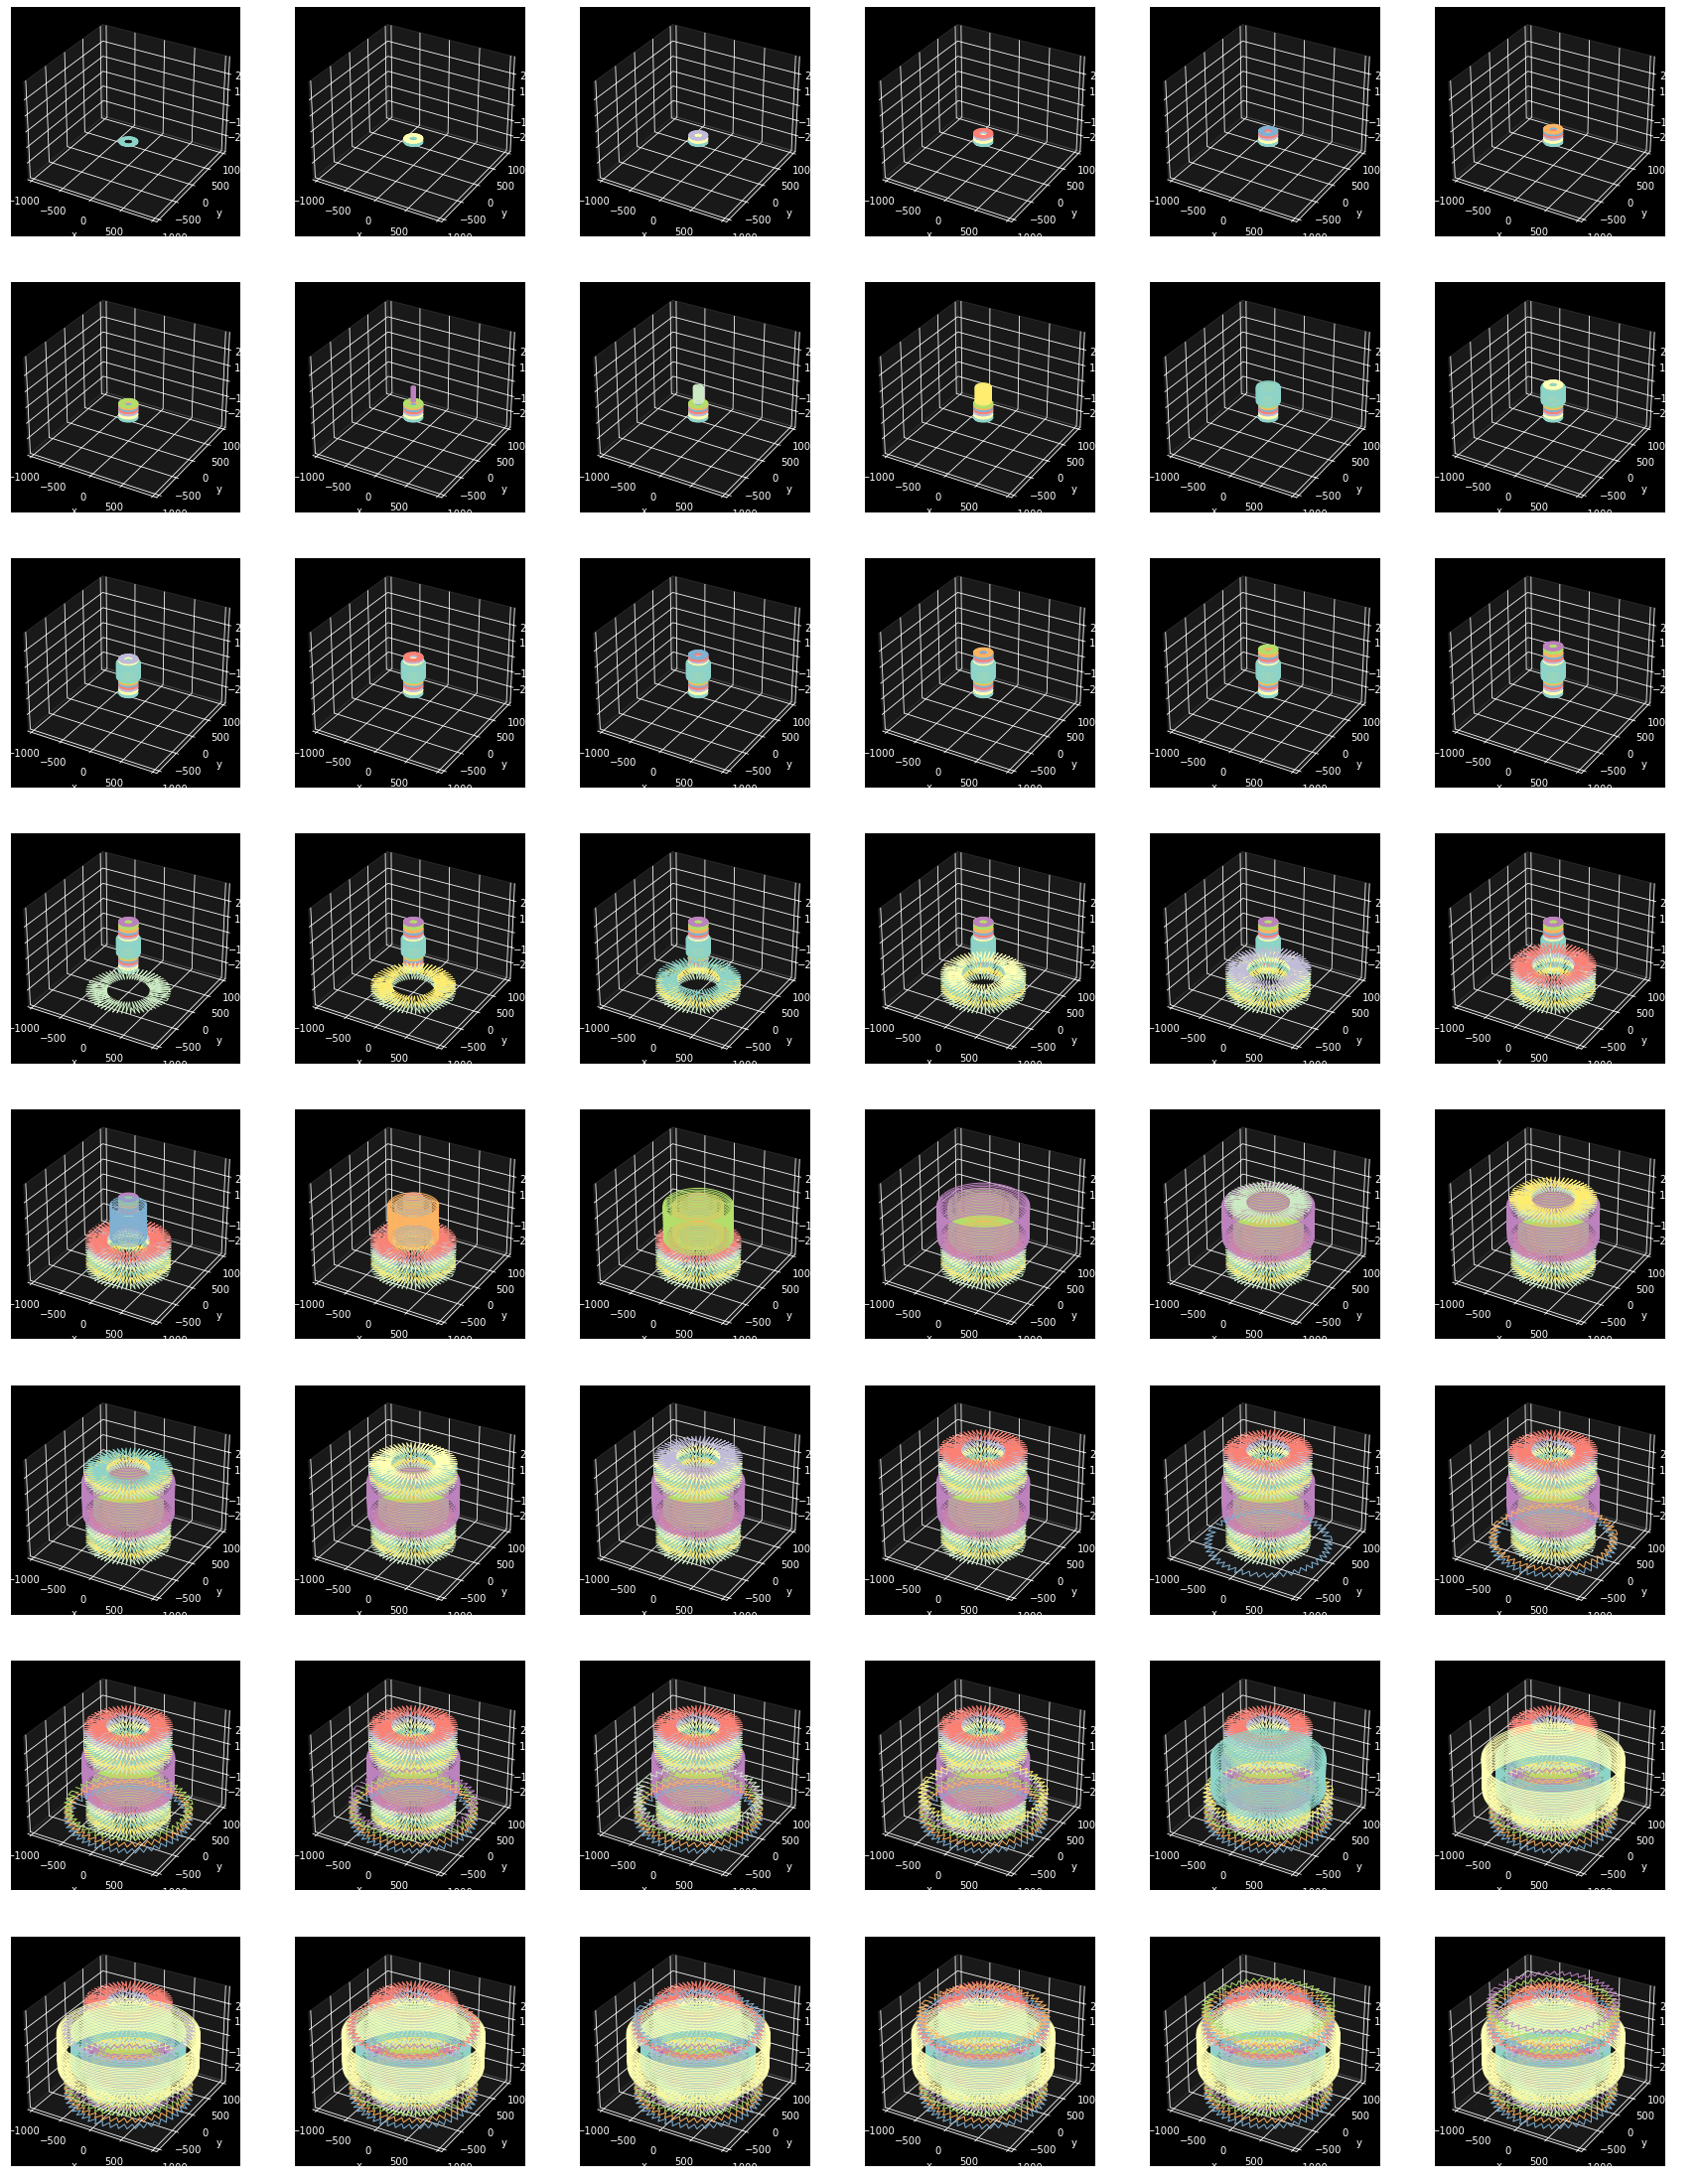

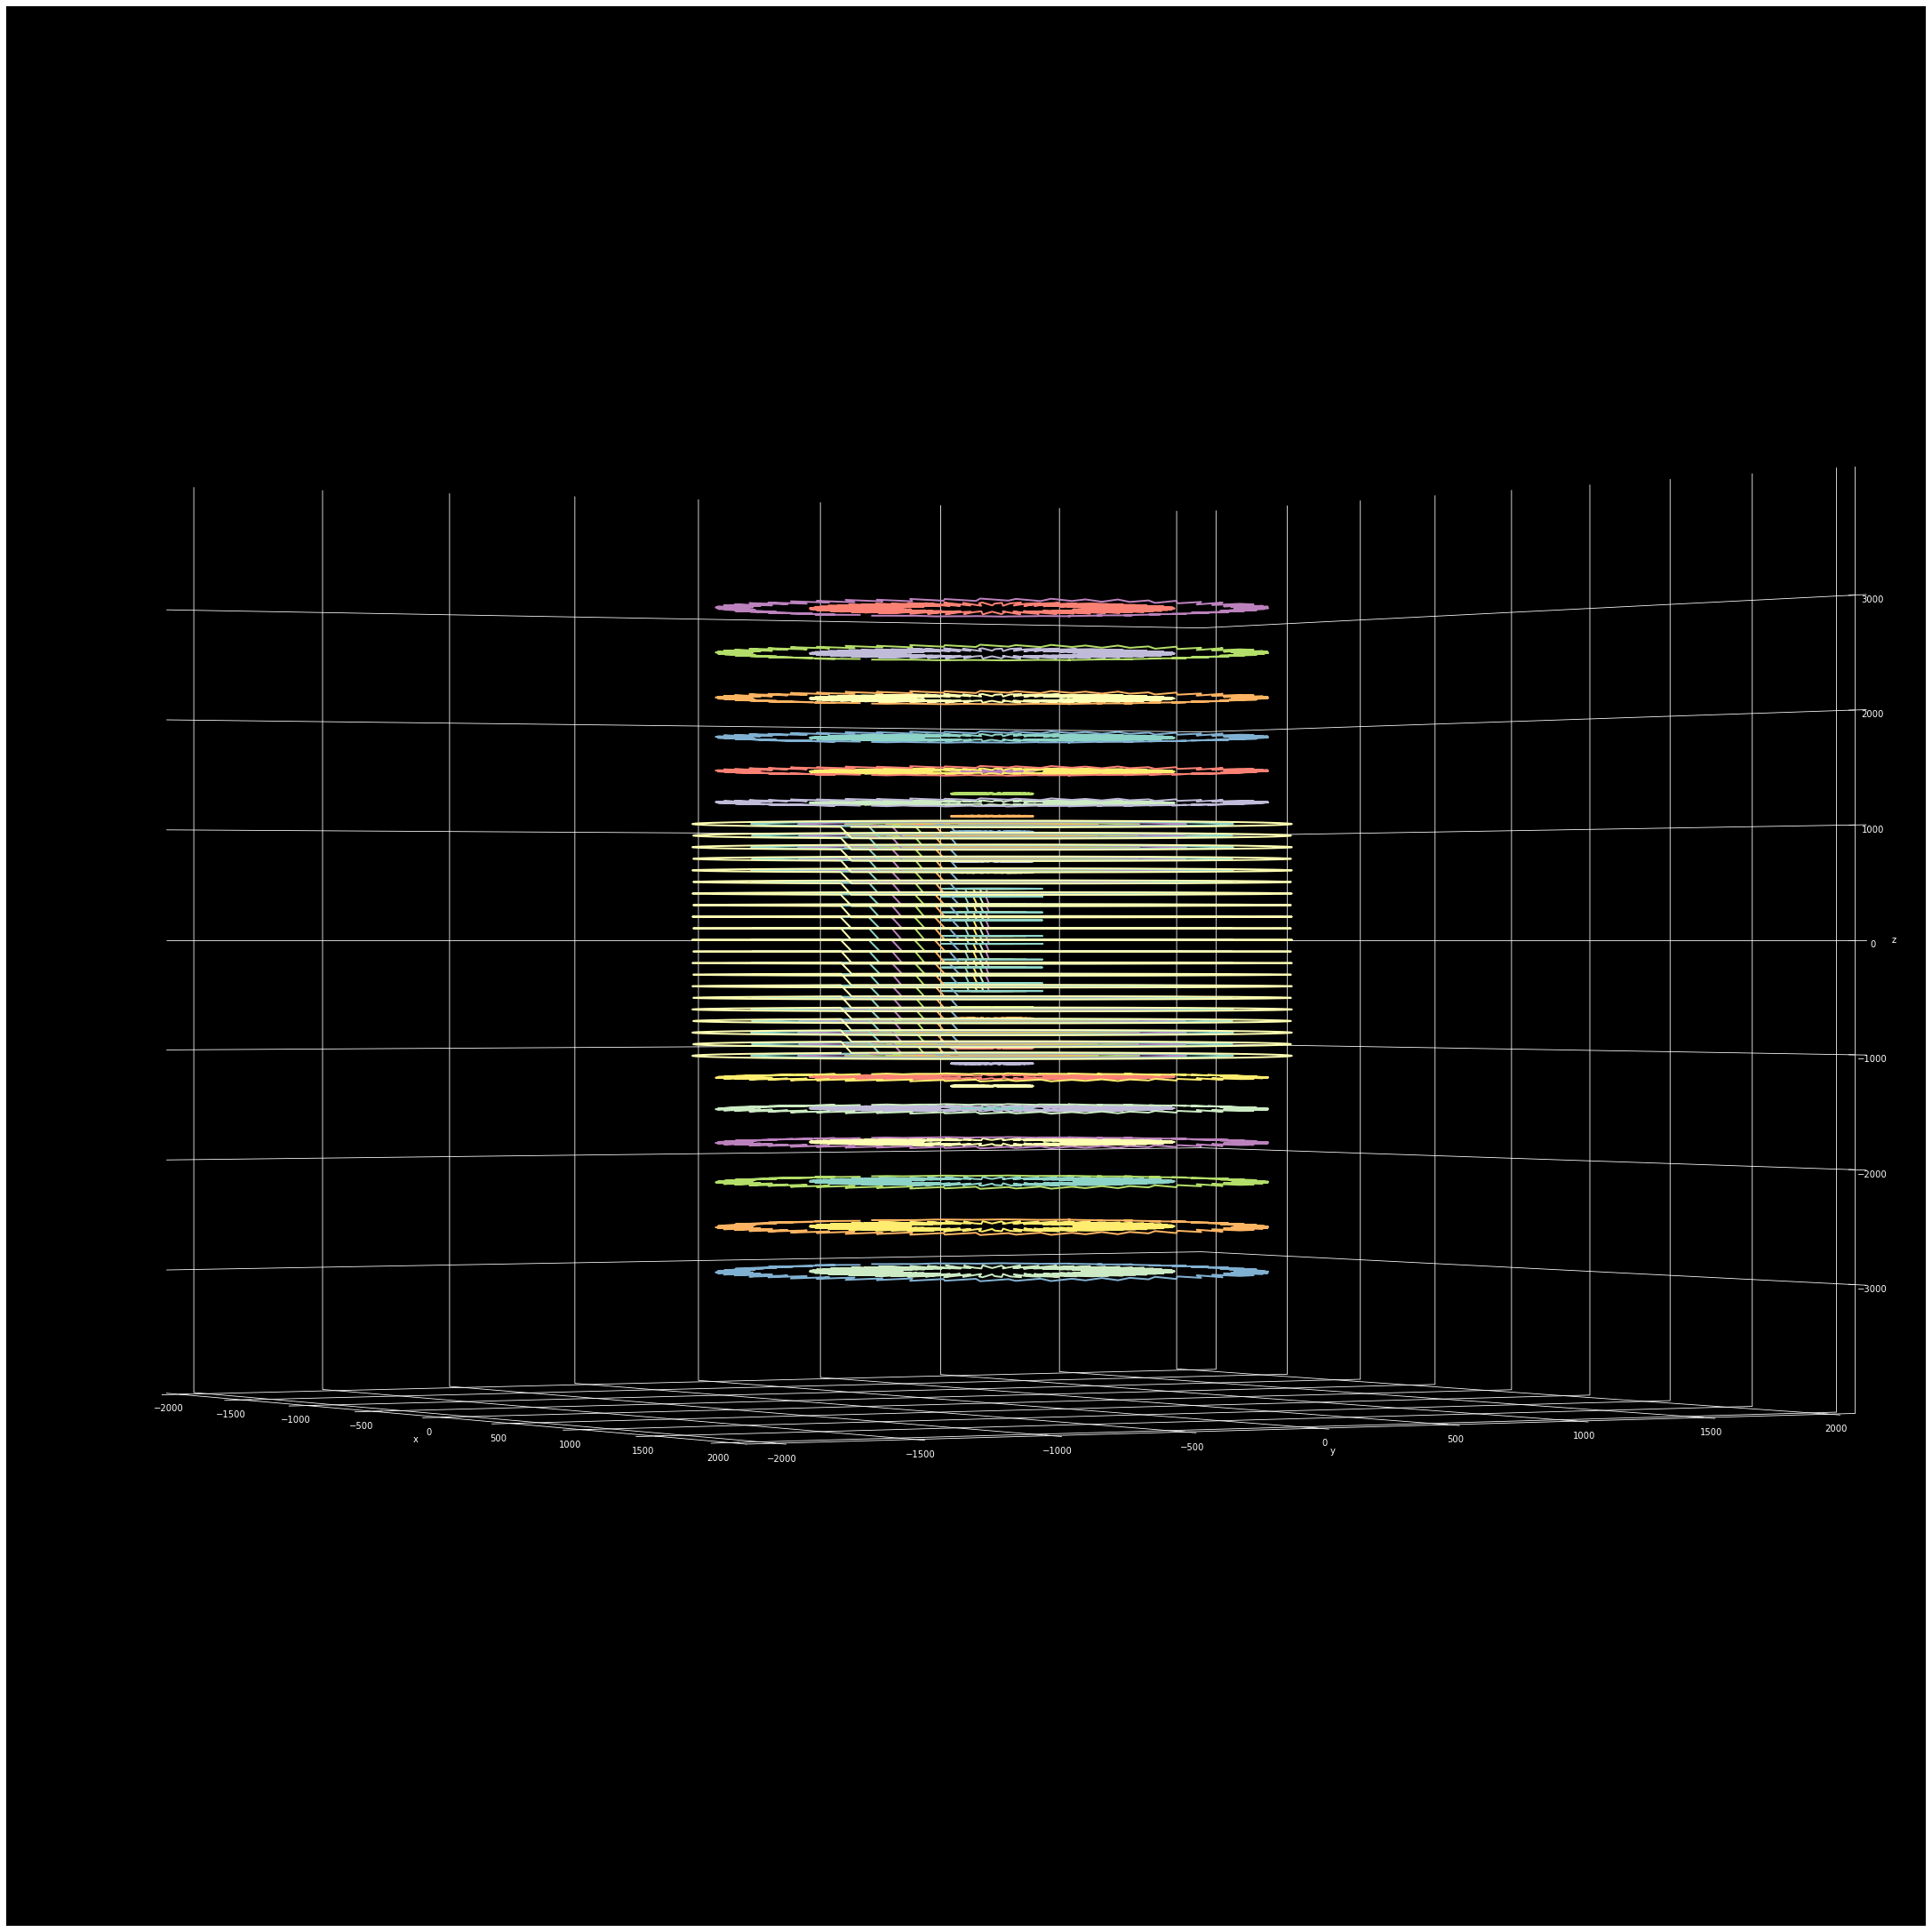

In [9]:
# Plotting the detector layers to have a clearer understanding
fig = plt.figure(figsize=(30, 40))
fig2 = plt.figure(figsize=(30, 160))

plt.style.use('dark_background')

for k in range(len(groupby)):
    
    ax, ax2 = fig.add_subplot(8, 6, k+1, projection='3d'), fig2.add_subplot(projection='3d')
    # Setting Labels, limits and colors of the graf
    ax.set_aspect('auto');                          ax2.set_aspect('auto')
    ax.set_xlabel('x');                             ax2.set_xlabel('x')
    ax.set_ylabel('y');                             ax2.set_ylabel('y')
    ax.set_zlabel('z');                             ax2.set_zlabel('z')
    ax.set_xlim(xmin, xmax);                        ax2.set_xlim(xmin-1000, xmax+1000)
    ax.set_ylim(ymin, ymax);                        ax2.set_ylim(ymin-1000, ymax+1000)
    ax.set_zlim(zmin, zmax);                        ax2.set_zlim(zmin-1000, zmax+1000)
    ax.xaxis.set_pane_color((1, 1, 1, 0.1));       ax2.xaxis.set_pane_color((1, 1, 1, 0))
    ax.yaxis.set_pane_color((1, 1, 1, 0.1));       ax2.yaxis.set_pane_color((1, 1, 1, 0))
    ax.zaxis.set_pane_color((1, 1, 1, 0.1));       ax2.zaxis.set_pane_color((1, 1, 1, 0))
    # Rotating the last graf for a better concept
    ax2.view_init(0, -30)
    
    for (idx, row) in groupby.iloc[:k+1].iterrows():
        xyz = np.array(row['xyz'])
        x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
        ax.plot(x, y, z, linewidth=1)
        ax2.plot(x, y, z, linewidth=2)
plt.tight_layout(pad=0., w_pad=0., h_pad=0.)

plt.show()


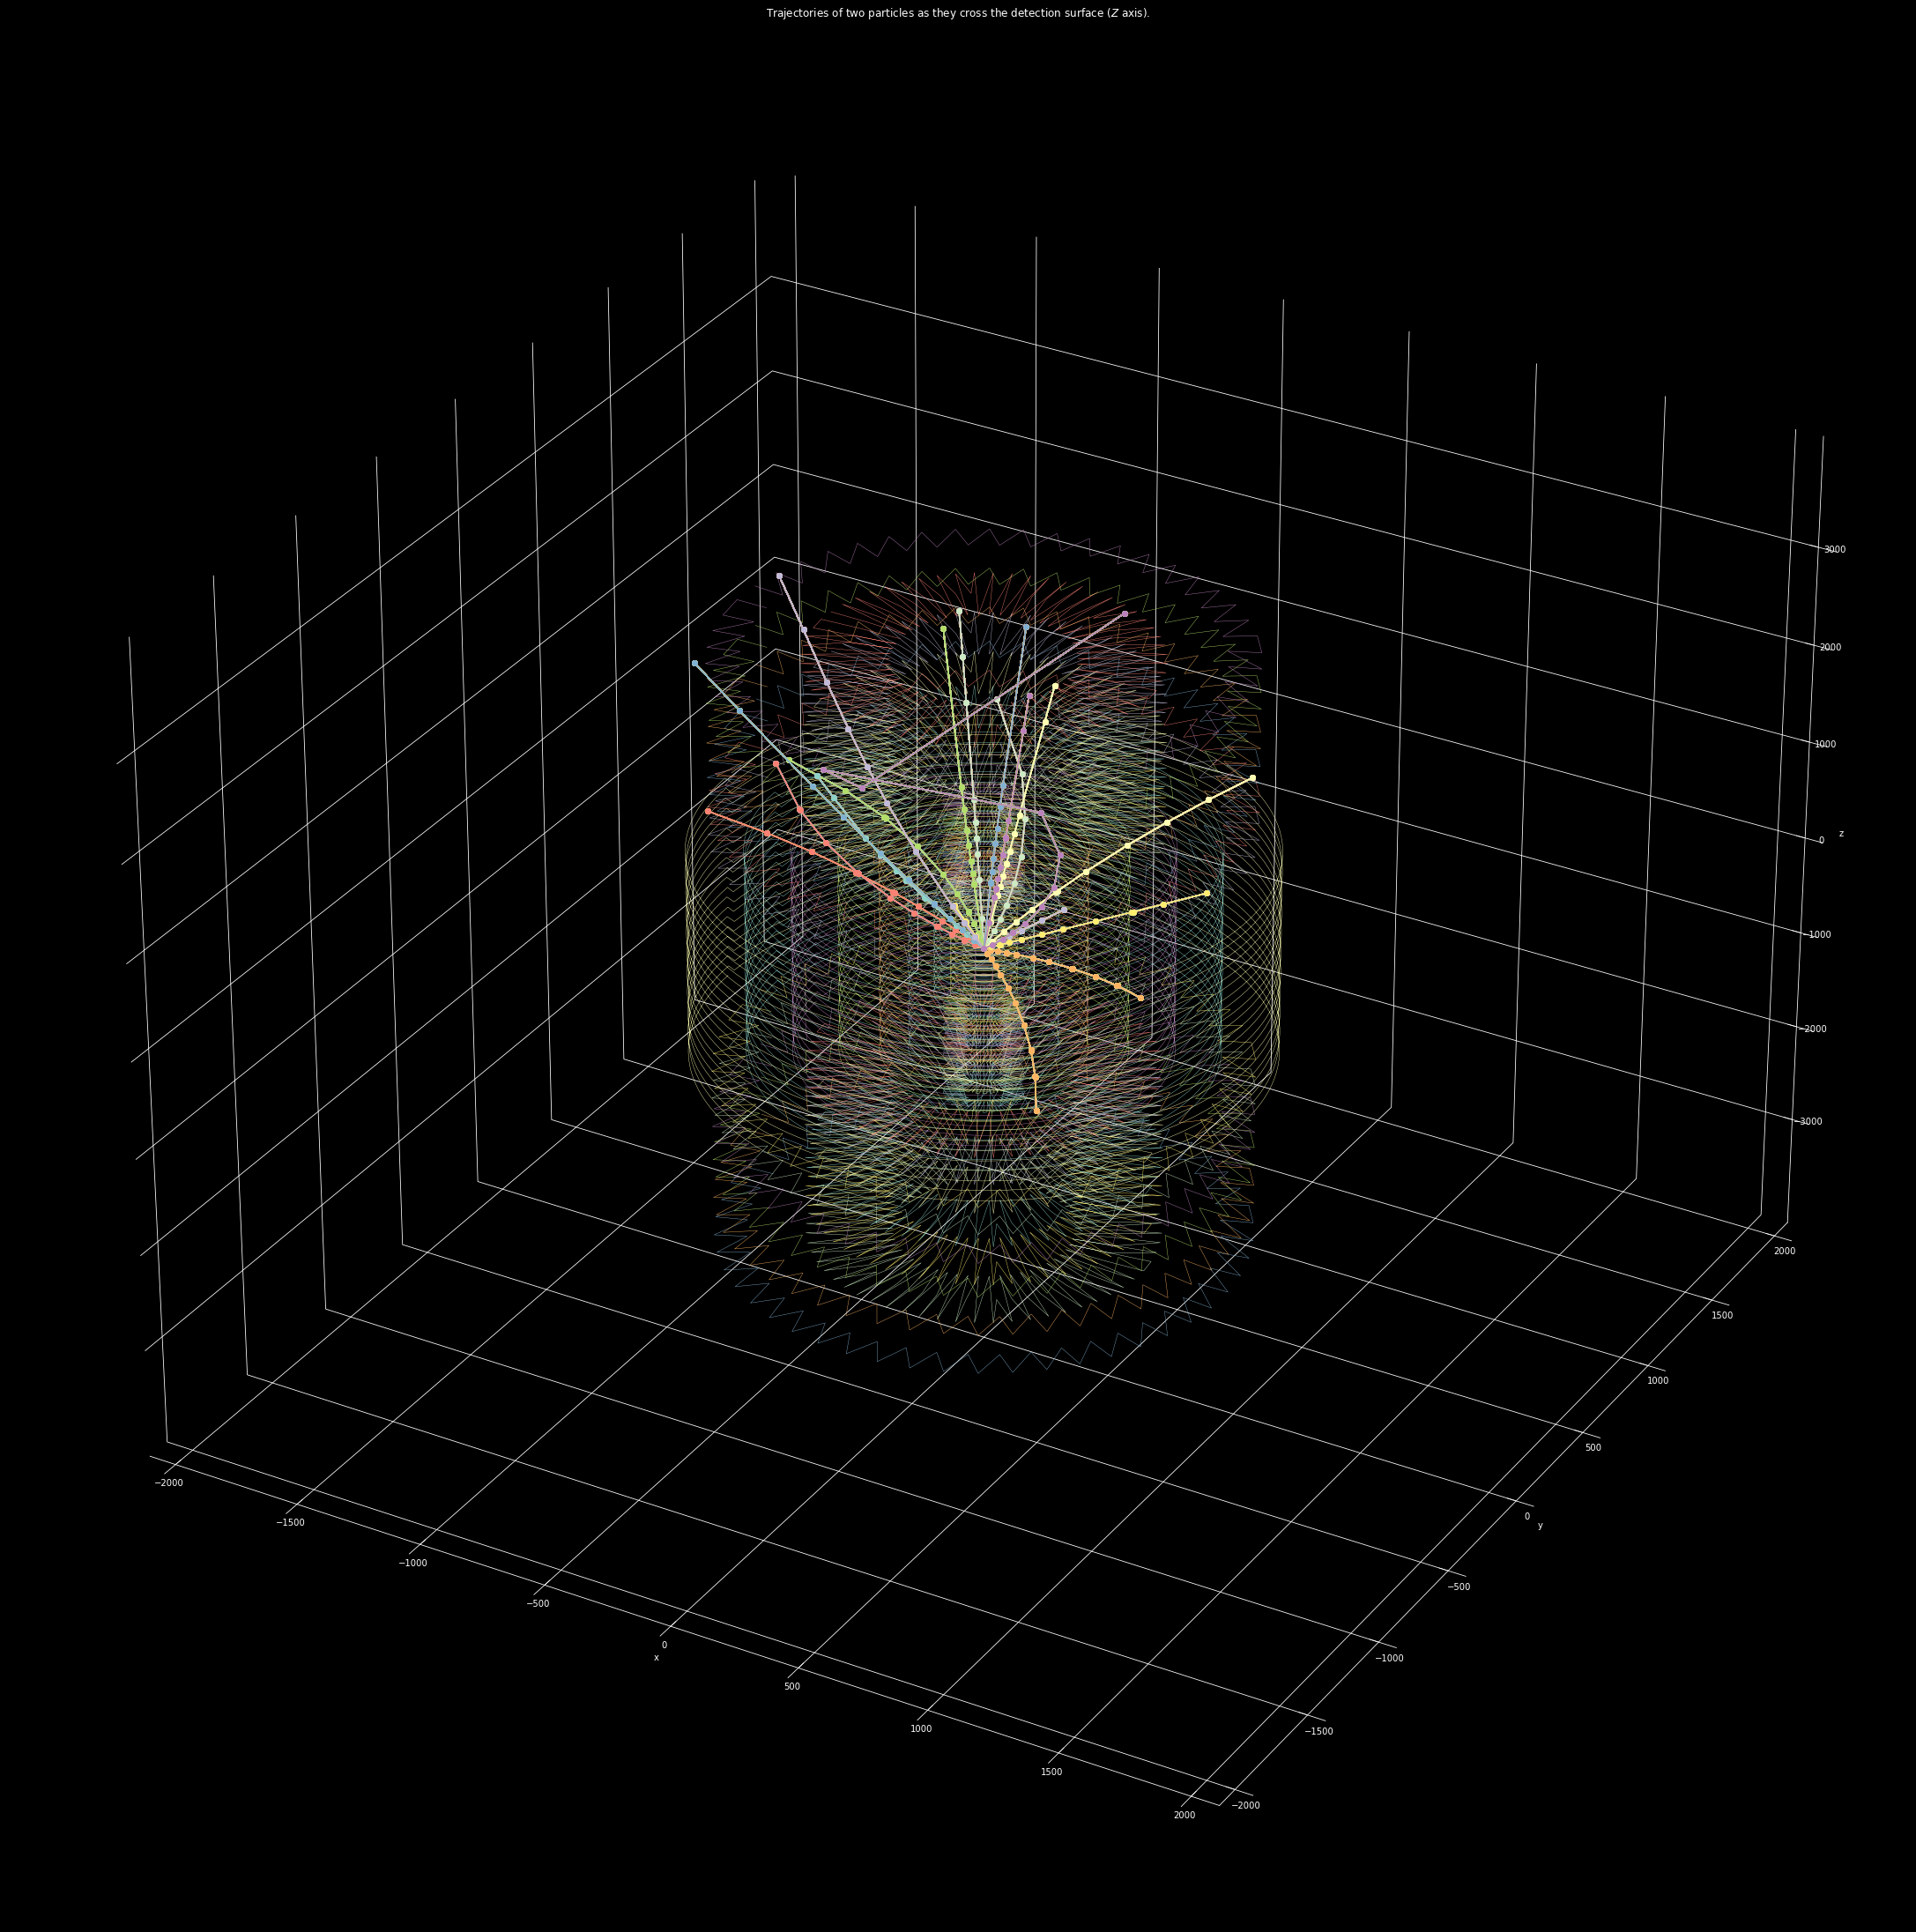

In [10]:

for i in range(0, len(particles.loc[particles.nhits])):
    # This will generate particle1, particle2...varibles =  particles.loc[particles.nhits].iloc[0,1...]
    exec("particle%d = particles.loc[particles.nhits].iloc[%d]" % ((i + 1), i));
    exec("p_traj_surface%d = truth[truth.particle_id == particle%d.particle_id][['tx', 'ty', 'tz']]" % ((i + 1), (i+1)));
    exec("p_traj%d = (p_traj_surface%d.append({'tx': particle%d.vx, 'ty': particle%d.vy, 'tz': particle%d.vz}, ignore_index=True).sort_values(by='tz'))" % ((i + 1), (i + 1), (i + 1), (i + 1), (i + 1)));

fig3 = plt.figure(figsize=(30, 160))

plt.style.use('dark_background')


ax3 = fig3.add_subplot(111, projection='3d')
ax3.set_aspect('auto'); 


for k in range(groupby.shape[0]):
    
    ax3 = fig3.add_subplot(111, projection='3d')
    
    ax3.set_aspect('auto'); 
    ax3.set_xlabel('x'); 
    ax3.set_ylabel('y');    
    ax3.set_zlabel('z');  
    ax3.set_xlim(xmin-1000, xmax+1000);    
    ax3.set_ylim(ymin-1000, ymax+1000);     
    ax3.set_zlim(zmin-1000, zmax+1000);  
    ax3.xaxis.set_pane_color((1, 1, 1, 0))
    ax3.yaxis.set_pane_color((1, 1, 1, 0))
    ax3.zaxis.set_pane_color((1, 1, 1, 0))
     
    for (idx, row) in groupby.iloc[:k+1].iterrows():
        xyz = np.array(row['xyz'])
        x, y, z = xyz[:,0], xyz[:,1], xyz[:,2]
        ax3.plot(x, y, z, linewidth=0.4)
        
for i in range(0, len(particles.loc[particles.nhits])):
    exec("ax3.plot( xs=p_traj%d.tx, ys=p_traj%d.ty, zs=p_traj%d.tz, marker='o')" % ((i + 1), (i + 1), (i + 1)));


plt.tight_layout(pad=0., w_pad=0., h_pad=0.)
plt.title('Trajectories of two particles as they cross the detection surface ($Z$ axis).')





plt.show()


In [16]:

# Get particle id with max number of hits in this event

ipv.figure(figsize=(30, 160))
ipv.style.use('dark')
colors= sns.color_palette('Spectral')
colors= colors.as_hex()
for i in range(0, len(particles.loc[particles.nhits == particles.nhits.max()])):
    # This will generate particle1, particle2...varibles =  particles.loc[particles.nhits == particles.nhits.max()].iloc[0,1...]
    exec("particle%d = particles.loc[particles.nhits == particles.nhits.max()].iloc[%d]" % ((i + 1), i));
    exec("p_traj_surface%d = truth[truth.particle_id == particle%d.particle_id][['tx', 'ty', 'tz']]" % ((i + 1), (i+1)));
    exec("p_traj%d = (p_traj_surface%d.append({'tx': particle%d.vx, 'ty': particle%d.vy, 'tz': particle%d.vz}, ignore_index=True).sort_values(by='tz'))" % ((i + 1), (i + 1), (i + 1), (i + 1), (i + 1)));
    exec("ipv.scatter( x=p_traj%d.tx, y=p_traj%d.ty, z=p_traj%d.tz, color=colors[%d], marker='sphere')" % ((i + 1), (i + 1), (i + 1), i));  
    ipv.xlim(xmin-1000, xmax+1000)
    ipv.ylim(ymin-1000, ymax+1000)
    ipv.zlim(zmin-1000, zmax+1000)

ipv.show()

#fca55d


In [ ]:

for i in range(0, len(particles.loc[particles.nhits == particles.nhits.max()])):
    # This will generate particle1, particle2...varibles =  particles.loc[particles.nhits == particles.nhits.max()].iloc[0,1...]
    exec("particle%d = particles.loc[particles.nhits == particles.nhits.max()].iloc[%d]" % ((i + 1), i));
    exec("p_traj_surface%d = truth[truth.particle_id == particle%d.particle_id][['tx', 'ty', 'tz']]" % ((i + 1), (i+1)));
    exec("p_traj%d = (p_traj_surface%d.append({'tx': particle%d.vx, 'ty': particle%d.vy, 'tz': particle%d.vz}, ignore_index=True).sort_values(by='tz'))" % ((i + 1), (i + 1), (i + 1), (i + 1), (i + 1)));
    exec("ax.plot( xs=p_traj%d.tx, ys=p_traj%d.ty, zs=p_traj%d.tz, marker='o')" % ((i + 1), (i + 1), (i + 1)));
